## Applying the bias scan tool on a BERT disinformation classifier
In this notebook, the bias scan tool is applied on a BERT-based disinformation classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan tool report](https://github.com/NGO-Algorithm-Audit/Bias_scan/blob/master/Bias_scan_tool_report.pdf).

The classifier is used to make predictions on the Twitter15\*\* data set. Details on pre-processing steps performed on this dataset are provided in the `../data/Twitter_dataset/Twitter_preprocessing.ipynb` notebook. Details on training the BERT disinformation classifier is provided in the `../case_studies/BERT_disinformation_classifier/BERT_Twitter_classifier.ipynb` notebook.

This notebook is structured as follows:
1. Load data and pre-processing
2. Bias scan using k-means clustering
3. Clustering results
4. Statistical testing of inter-cluster difference 

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* Liu, Xiaomo and Nourbakhsh, Armineh and Li, Quanzhi and Fang, Rui and Shah, Sameena, *Proceedings of the 24th ACM International on Conference on Information and Knowledge Management* (2015) [[link to dataset]](https://www.dropbox.com/s/7ewzdrbelpmrnxu/rumdetect2017.zip?dl=0&file_subpath=%2Frumor_detection_acl2017)

### Load libraries

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# IPython
from IPython.display import Markdown, display

# matplotlib
import matplotlib.pyplot as plt

# helper functions
from helper_functions import *

# welch's t-test
import scipy.stats as stats

warnings.filterwarnings('ignore')

### 1. Load data and pre-processing

In [2]:
# read data
path = '../case_studies/BERT_disinformation_classifier/pred_BERT.csv'
df_pred = pd.read_csv(path)

# change column names
df_pred.columns = ['text','predicted_class','true_class']

# Calculating absolute errors
df_pred['errors'] = abs(df_pred['predicted_class'] - df_pred['true_class'])
df_pred.head()

,text,predicted_class,true_class,errors
0,marlboro man dies of smoking-related disease U...,0,1,1
1,#oklahoma prosecutor files formal notification...,0,0,0
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0
3,who killed deandre joshua - and why? still mor...,1,0,1
4,i feel some type of way. URL,1,1,0


#### Add features to data

In [3]:
path_feat = '../data/Twitter_dataset/twitter_full.csv'
df_feat = pd.read_csv(path_feat)
df_feat.head(2)

,#followers,user_engagement,verified,depth,user_id1,tweet_id1,user_id2,length,#hashs,#mentions,#URLs,sentiment_score,text,label
0,15375121,72.567469,1,0.0,ROOT,489800427152879616,2467791,95,0,0,2,-0.3182,malaysia airlines says it lost contact with pl...,1
1,3673898,55.294333,1,0.0,ROOT,560474897013415936,59553554,118,0,1,1,0.8398,for just $1 you can get a free jr. frosty with...,1


#### Data cleaning

In [4]:
df_full = pd.merge(df_pred, df_feat, on=['text'])

# remove certain columns
df_full = df_full.drop(columns=['depth', 'user_id1', 'user_id2','label'])

# features
features = df_full.drop(['text','predicted_class', 'true_class', 'errors'], axis=1)
features.head()

df_full.head()

,text,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score
0,marlboro man dies of smoking-related disease U...,0,1,1,2881966,48.857582,1,427846006600777729,52,0,0,2,0.0000
1,#oklahoma prosecutor files formal notification...,0,0,0,2432446,4.103050,1,517850508380618752,124,3,0,0,-0.8442
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0,4144151,9.042582,1,520630231531802624,102,1,0,2,-0.7184
3,who killed deandre joshua - and why? still mor...,1,0,1,606870,6.919301,1,539833716852273152,117,0,0,1,-0.8720
4,i feel some type of way. URL,1,1,0,2528852,11.271492,1,524320261667950592,28,0,0,1,0.0000


#### Data initialization

In [11]:
full_data = init_dataset(df_full,features)
full_data.head()

,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
0,0,1,1,-0.249684,-0.063442,0.498224,-1.230690,-1.607344,-0.513855,-0.325831,0.921514,0.423952,0,-1
1,0,0,0,-0.299704,-0.901957,0.498224,0.305262,1.519500,4.912457,-0.325831,-2.054385,-1.463204,0,-1
2,0,0,0,-0.109236,-0.809411,0.498224,0.352699,0.564075,1.294915,-0.325831,0.921514,-1.181986,0,-1
3,1,0,1,-0.502843,-0.849192,0.498224,0.680412,1.215501,-0.513855,-0.325831,-0.566435,-1.525350,0,-1
4,1,1,0,-0.288977,-0.767650,0.498224,0.415671,-2.649625,-0.513855,-0.325831,-0.566435,0.423952,0,-1


In [12]:
# full_data = full_data.drop(['clusters','new_clusters'],axis=1)

In [13]:
full_data.head()

,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
0,0,1,1,-0.249684,-0.063442,0.498224,-1.230690,-1.607344,-0.513855,-0.325831,0.921514,0.423952,0,-1
1,0,0,0,-0.299704,-0.901957,0.498224,0.305262,1.519500,4.912457,-0.325831,-2.054385,-1.463204,0,-1
2,0,0,0,-0.109236,-0.809411,0.498224,0.352699,0.564075,1.294915,-0.325831,0.921514,-1.181986,0,-1
3,1,0,1,-0.502843,-0.849192,0.498224,0.680412,1.215501,-0.513855,-0.325831,-0.566435,-1.525350,0,-1
4,1,1,0,-0.288977,-0.767650,0.498224,0.415671,-2.649625,-0.513855,-0.325831,-0.566435,0.423952,0,-1


### 2. HBAC using k-means clustering

Clustering algorithms parameters:

In [14]:
clustering_paramaters = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [15]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  9
minimal splitacceptabletable cluster size:  5


Performing bias scan using helper functions.

In [16]:
iterations_max = 20
x = 0 # initial cluster number
initial_bias = 0
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, iterations_max):
    if i != 1:
        
        # calculate variance for cluster
        variance_list.append(calculate_variance(full_data)) 
        
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # k-means clustering 
    kmeans_algo = KMeans(**clustering_paramaters).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    # with get_max_abs_bias, but now it only finds the discriminated clusters
    max_abs_bias = get_max_negative_bias(full_data) 
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size):
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('done')

average_accuracy is:  0.8352272727272727
done


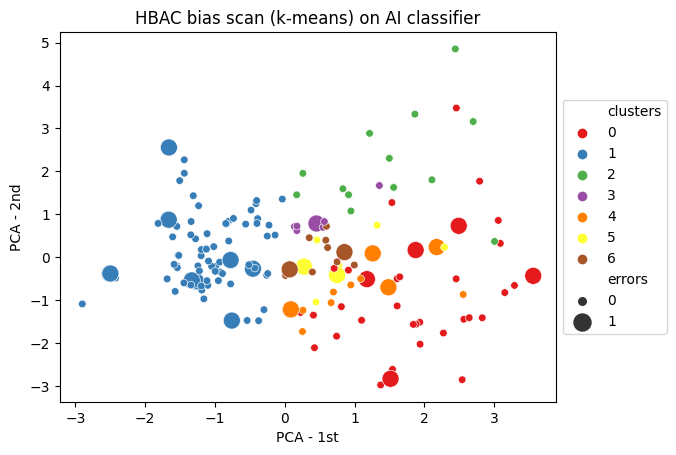

In [18]:
pca_plot(full_data)

### 3. Analysing clustering results

Identifying cluster with most negative bias.

In [19]:
c = get_max_bias_cluster(full_data)
max_bias = round(bias_acc(full_data, c, "clusters"), 2)
highest_biased_cluster = full_data[full_data['clusters']==c]
print(f"cluster {c} has the highest negative bias: " + str(max_bias))
print("#elements in highest biased cluster:", len(highest_biased_cluster))

1 has bias 0.026397515527950333
2 has bias 0.17791411042944782
3 has bias 0.02282333051563812
0 has bias 0.027355623100303927
5 has bias -0.1259509721048182
6 has bias -0.03734939759036138
4 has bias -0.27032520325203246
cluster 4 has the highest negative bias: -0.27
#elements in highest biased cluster: 12


Top-5 differing features per cluster 

In [24]:
for c in range(0,7):
    print(f"Cluster {c} has bias xx")
    
    # discriminated cluster
    discriminated_cluster = full_data[full_data['clusters']==c]
    
    # statistical testing
    not_discriminated = full_data[full_data['clusters']!=c]
    difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
    diff_dict = difference.to_dict()
    
    ## unscaling data
    # discriminated cluster
    unscaled_discriminated = full_data.loc[discriminated_cluster.index, :]

    # unscaled other data
    unscaled_remaining = full_data.drop(discriminated_cluster.index)
    
    # welch t-test
    welch_dict = {}

    features = [col for col in full_data.columns.tolist() if col not in ['tweet_id1','scaled_errors','predicted_class','true_class','errors','clusters','new_clusters']]

    for i in features:
        welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)

        # attach to dictionary
        welch_dict[i] = welch_i.pvalue
        
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    cluster_analysis_df = pd.DataFrame([diff_dict, welch_dict]).T
    cluster_analysis_df.columns = ['difference','p-value']
    cluster_analysis_df = cluster_analysis_df.sort_values('p-value')
    print(cluster_analysis_df)

Cluster 0 has bias xx
                 difference  p-value
verified           -2.50535  0.00000
#followers         -0.68370  0.00000
user_engagement    -0.81632  0.00000
#URLs              -0.91930  0.00005
#hashs              0.32620  0.15808
sentiment_score     0.11758  0.57710
#mentions           0.08413  0.69725
length             -0.08115  0.70729
predicted_class     0.10314      NaN
true_class          0.08916      NaN
errors             -0.02736      NaN
tweet_id1          -0.63922      NaN
clusters           -2.00000      NaN
new_clusters        0.00000      NaN
Cluster 1 has bias xx
                 difference  p-value
#URLs               1.42249  0.00000
user_engagement     1.04179  0.00000
verified            1.04390  0.00000
#followers          0.71614  0.00000
length             -0.69832  0.00000
#mentions          -0.57821  0.00024
#hashs             -0.41755  0.00689
sentiment_score    -0.13971  0.36220
predicted_class     0.01501      NaN
true_class          0.02277    